# Restricted Boltzmann Machines

### Energy-based model
Energy-based models associate a scalar energy to each configuration of the variables of interest. Low energy is more desirable. The probability distribution based on an energy function can be defined as follows
$$ \Pr(x) = \frac{\exp (-E(x))}{Z}\,,$$
where $Z = \sum_{x} \exp (-E(x))$ denotes the normalization factor or **partition function**. 

### Restricted Boltzmann Machine

Restricted Boltzmann Machine (RBM) has an efficient training algorithm. In order to increase the expressive power of the model, we do not observe the example $x$ fully, we also want to introduce some non-observed variables.  Consider an observed part $x$ and a hidden part $h$. We can then write:<br>
$$\Pr(x) = \sum_h \frac{\exp (-E(x, h))}{Z} \,.$$

In RBM, the energy function is defined as<br>
$$
E(x, h) = -a^\top x - b^\top h - x^\top W h \,.
$$

To make RBM as an energy-based model, the free energy function is computed as follows<br>
$$
\begin{align}
F(x) &= -\log \sum_h \exp (-E(x, h)) \\
     &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
\end{align}
$$

We have an tractable expression for the conditional probabilities<br>
$$
\Pr (h|x) = \prod_i \Pr (h_i | x)
$$

> ### This is a basic implementation of a Restricted Boltzmann Machine (RBM). RBMs are a type of generative model that can learn to represent and generate data that is similar to the input data they are trained on. They are particularly good at learning to represent data with binary values. They can be used for dimensionality reduction, feature extraction, and collaborative filtering for recommender systems. They can also be stacked to create Deep Belief Networks (DBNs).

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

In [17]:
batch_size = 64 # batch size
n_epochs = 10 # number of epochs
lr = 0.01 # learning rate
n_hid = 128 # number of neurons in the hidden layer
n_vis = 784 # input size
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


> The free energy of a visible vector `v` in an RBM is given by the formula:<br>
$$F(v) = -a^\top v - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))$$
>> Here's what each term represents:
>> - **`a`** is the bias of the visible units.
>> - **`v`** is the visible units.
>> - **`W`** is the weight matrix.
>> - **`x`** is the hidden units.
>> - **`b`** is the bias of the hidden units.
>_______________________
> The free energy function is used to compute the probability of a visible vector `v`. Lower free energy means higher probability.
>> - The first term $$-a^\top v$$ is the dot product of the visible bias `a` and the visible vector `v`. This term increases the free energy for configurations of the visible units that are not aligned with the bias.

>> - The second term $$-\sum_j \log (1 + \exp(W^{\top}_jx + b_j))$$ is a sum over all hidden units. For each hidden unit, it computes the log of one plus the exponential of the dot product of the corresponding row of the weight matrix `W` and the visible vector `v`, plus the bias of the hidden unit. This term increases the free energy for configurations of the visible units that are not aligned with the weights and biases of the hidden units.

> - In the context of training an RBM, the goal is to adjust the weights and biases to minimize the free energy of the training data and maximize the free energy of the samples generated by the model. This makes the training data more likely and the generated samples less likely under the model's distribution. The difference in free energy between a data vector and a sample vector is used as a loss function for training the RBM. The gradients of this loss function with respect to the weights and biases are computed and used to update the weights and biases. This process is repeated for a number of epochs to train the RBM. 

In [42]:
# free energy example:
# Assume we have an RBM with the following parameters:
v = torch.randn(1, 784)  # visible bias
h = torch.randn(1, 128)  # hidden bias
W = torch.randn(128, 784)  # weight matrix
print(W.shape)
# And we have a visible vector:
visible_vector = torch.randn(1, 784)

# We can compute the free energy as follows:
v_term = torch.matmul(visible_vector, v.t())
w_x_h = F.linear(visible_vector, W, h)
h_term = torch.sum(F.softplus(w_x_h), dim=1)
free_energy = torch.mean(-h_term - v_term)

print(free_energy)

torch.Size([128, 784])
tensor(-1137.0376)


In [5]:
# nn.Module is the base class for all neural network modules in PyTorch.
class RBM(nn.Module):
    r"""Restricted Boltzmann Machine.

    Args:
        n_vis (int, optional): The size of visible layer. Defaults to 784.
        n_hid (int, optional): The size of hidden layer. Defaults to 128.
        k (int, optional): The number of Gibbs sampling. Defaults to 1.
    """
    # This is the constructor of the RBM class. It takes three arguments: 
    # the number of visible units, the number of hidden units, and the number of Gibbs sampling steps.
    def __init__(self, n_vis=784, n_hid=128, k=1):
        """Create a RBM."""
        # This line calls the constructor of the parent class nn.Module
        super(RBM, self).__init__()
        # This line initializes the visible bias v as a parameter with random values.
        self.v = nn.Parameter(torch.randn(1, n_vis))
        # This line initializes the hidden bias h as a parameter with random values.
        self.h = nn.Parameter(torch.randn(1, n_hid))
        # This line initializes the weight matrix W as a parameter with random values.
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        # This line sets the number of Gibbs sampling steps.
        self.k = k

    # This method performs the forward pass,
    # it computes the probabilities of the hidden units given the visible units and samples from these probabilities.
    def visible_to_hidden(self, v):
        r"""Conditional sampling a hidden variable given a visible variable.

        Args:
            v (Tensor): The visible variable.

        Returns:
            Tensor: The hidden variable.

        """
        # This line computes the probabilities of the hidden units.
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        # This line samples from the computed probabilities using a Bernoulli distribution.
        return p.bernoulli()

    # This method performs the backward pass,
    # it computes the probabilities of the visible units given the hidden units and samples from these probabilities.
    def hidden_to_visible(self, h):
        r"""Conditional sampling a visible variable given a hidden variable.

        Args:
            h (Tendor): The hidden variable.

        Returns:
            Tensor: The visible variable.

        """
        # This line computes the probabilities of the hidden units.
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        # This line samples from the computed probabilities using a Bernoulli distribution.
        return p.bernoulli()

    # This method computes the free energy of the visible units.
    def free_energy(self, v):
        r"""Free energy function.

        .. math::
            \begin{align}
                F(x) &= -\log \sum_h \exp (-E(x, h)) \\
                &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
            \end{align}

        Args:
            v (Tensor): The visible variable.

        Returns:
            FloatTensor: The free energy value.

        """
        # This line computes the first term in the free energy function.
        v_term = torch.matmul(v, self.v.t())
        # This line computes the product of the visible units and the weights.
        # F.linear is a function that computes a linear transformation of the data
        w_x_h = F.linear(v, self.W, self.h)
        # This line computes the second term in the free energy function.
        # F.softplus is a function that applies the element-wise function log(1 + exp(x)).
        h_term = torch.sum(F.softplus(w_x_h), dim=1)
        # This line computes the mean free energy over the mini-batch.
        return torch.mean(-h_term - v_term)

    # This method performs one step of Gibbs sampling.
    def forward(self, v):
        r"""Compute the real and generated examples.

        Args:
            v (Tensor): The visible variable.

        Returns:
            (Tensor, Tensor): The real and generagted variables.

        """
        # This line computes the hidden units given the visible units.
        h = self.visible_to_hidden(v)
        # This line starts a loop for k steps of Gibbs sampling.
        for _ in range(self.k):
            # This line computes the visible units given the hidden units.
            v_gibb = self.hidden_to_visible(h)
            # This line computes the hidden units given the visible units.
            h = self.visible_to_hidden(v_gibb)
        # This line returns the original visible units and the visible units after k steps of Gibbs sampling.
        return v, v_gibb

In [19]:
# create a Restricted Boltzmann Machine
model = RBM(n_vis=n_vis, n_hid=n_hid, k=1)
model.to(device)

RBM()

In [20]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./output', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size
)

In [21]:
# The RBM is trained by minimizing the difference in free energy between the original and reconstructed visible units.
def train(model, train_loader, n_epochs=20, lr=0.01):
    r"""Train a RBM model.

    Args:
        model: The model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.

    Returns:
        The trained model.

    """
    # optimizer
    train_op = torch.optim.Adam(model.parameters(), lr)

    # train the RBM model
    # This line sets the model to training mode. This has any effect only on certain modules like Dropout and BatchNorm.
    model.train()

    for epoch in range(n_epochs):
        # This line initializes a list to store the loss values for each batch of data.
        loss_ = []
        # This line starts a loop over the batches of data. The data loader returns batches of data and their corresponding targets.
        for _, (data, target) in enumerate(train_loader):
            # This line passes a batch of data through the model and gets the original and reconstructed visible units.
            v, v_gibbs = model(data.to(device).view(-1, 784))
            # This line computes the loss for the batch of data. 
            # The loss is the difference in free energy between the original and reconstructed visible units.
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            # This line adds the loss for the current batch of data to the list of loss values.
            loss_.append(loss.item())
            # This line resets the gradients in the model before computing the gradients for the current batch of data.
            train_op.zero_grad()
            # This line computes the gradients of the loss with respect to the model parameters.
            loss.backward()
            # This line updates the model parameters using the computed gradients.
            train_op.step()

        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(loss_)))

    return model

In [24]:
model = train(model, train_loader, n_epochs=n_epochs, lr=lr)

Epoch 0	 Loss=0.9761
Epoch 1	 Loss=1.2274
Epoch 2	 Loss=1.2167
Epoch 3	 Loss=1.3471
Epoch 4	 Loss=1.6236
Epoch 5	 Loss=1.6967
Epoch 6	 Loss=1.6650
Epoch 7	 Loss=1.9613
Epoch 8	 Loss=1.9948
Epoch 9	 Loss=1.9817


In [25]:
def show_and_save(img, file_name):
    r"""Show and save the image.

    Args:
        img (Tensor): The image.
        file_name (Str): The destination.

    """
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    plt.imshow(npimg, cmap='gray')
    plt.imsave(f, npimg)

In [27]:
images = next(iter(train_loader))[0]
v, v_gibbs = model(images.to(device).view(-1, 784))

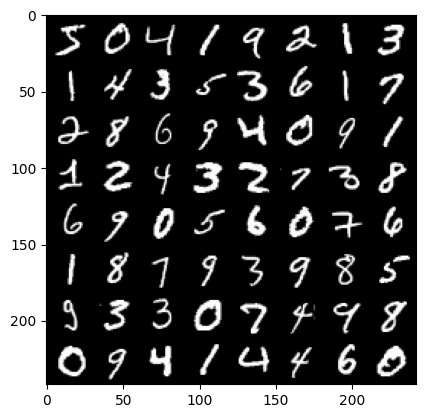

In [29]:
# show the real images
show_and_save(make_grid(v.cpu().view(batch_size, 1, 28, 28).data), 'output/real')

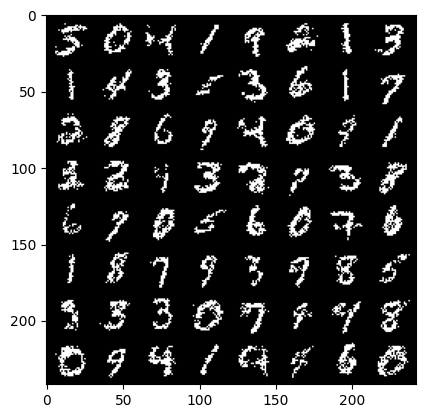

In [30]:
# show the generated images
show_and_save(make_grid(v_gibbs.cpu().view(batch_size, 1, 28, 28).data), 'output/fake')

## How one image is factorized through the hidden variables:

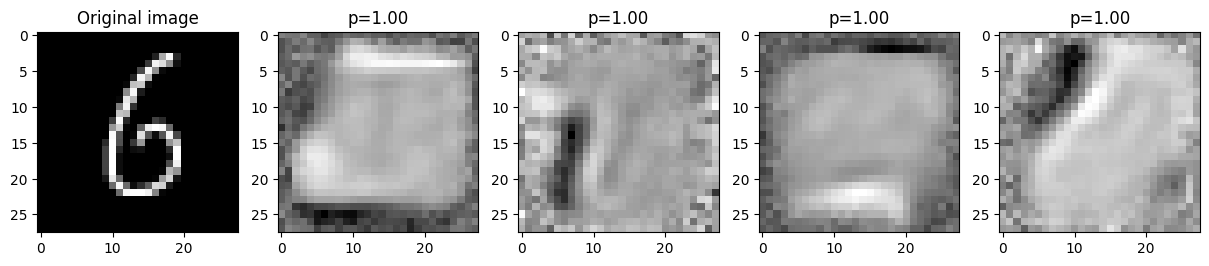

In [46]:
n_sample = 4
kth = 18
d = images[kth:kth+1]

V = torch.sigmoid(F.linear(d.view(1, -1), model.W.cpu(), model.h.cpu()))
v, o = torch.sort(V.view(-1))

fig, ax = plt.subplots(1, n_sample + 1, figsize=(3*(1 + n_sample),3))
ax[0].imshow(d.view(28, 28).numpy(), cmap='gray')
ax[0].set_title('Original image')

for k, i in enumerate(o[-n_sample:].numpy()):
    f = model.W[i].cpu().view(28, 28).data.numpy()
    ax[k + 1].imshow(f, cmap='gray')
    ax[k + 1].set_title('p=%.2f'% V[0][i].item())
    
plt.savefig('output/factor.png', dpi=200)

# END of RBM MNIST Digits